## Taller 8 AREP 2

Antes de empezar, necesitamos instalar LangChain y las dependencias necesarias. Dependiendo del entorno, en este caso usaremos pip

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


# Cargar Documentos

Se pueden cargar documentos desde diferentes formatos. En este caso, usaremos TextLoader para cargar un archivo de texto.
1. os.environ["LANGSMITH_TRACING"] = "true" → Activa el rastreo (tracing) en LangSmith.
2. os.environ["LANGSMITH_API_KEY"] = "..." → Guarda la clave API en una variable de entorno para autenticar el uso de LangSmith.

In [ ]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "acá va la clave"

Instala y actualiza LangChain con soporte para OpenAI.

In [23]:
pip install -qU "langchain[openai]"

Note: you may need to restart the kernel to use updated packages.


## Componentes

Este código configura una API de OpenAI en LangChain:

Manejo de variables de entorno → Configura la clave de API de OpenAI si no está definida.
Entrada segura → Solicita la clave de API de forma segura si es necesario.
Inicialización del modelo → Carga un modelo de lenguaje (gpt-4o-mini) de OpenAI para su uso en LangChain.

In [2]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

Este comando instala o actualiza silenciosamente (-qU) el paquete langchain-openai, que permite la integración de modelos de OpenAI en LangChain.

In [3]:
pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


Carga la clave de API de OpenAI y crea una instancia de OpenAIEmbeddings para convertir texto en vectores usando el modelo text-embedding-3-large.

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Instalar o actualizar silenciosamente el paquete langchain-core, que contiene las funcionalidades principales de LangChain.

In [4]:
pip install -qU langchain-core

Note: you may need to restart the kernel to use updated packages.


Crea un almacén de vectores en memoria utilizando los embeddings generados, permitiendo búsquedas eficientes de similitud.

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

El código carga y procesa el contenido de un blog, lo divide en fragmentos, los indexa en un vector store y luego implementa un sistema RAG. Este sistema recupera información relevante según una pregunta, genera una respuesta con un modelo de lenguaje y ejecuta el flujo con un grafo de estado.

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
new_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

NameError: name 'vector_store' is not defined

Ejecuta un grafo de razonamiento

In [ ]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

El código carga el contenido de una página web, filtrando solo los títulos, encabezados y el contenido principal. Luego, verifica que solo se haya obtenido un documento y muestra la cantidad de caracteres de su contenido.

In [10]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


Se imprime

In [11]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


# División

Nuestro documento cargado tiene más de 42 000 caracteres, lo cual es demasiado largo para caber en la ventana de contexto de muchos modelos. Incluso aquellos que pueden incluir la publicación completa en su ventana de contexto pueden tener dificultades para encontrar información en entradas muy largas.

Para solucionar esto, dividiremos el Documentarchivo en fragmentos para su incrustación y almacenamiento vectorial. Esto debería permitirnos recuperar solo las partes más relevantes de la entrada del blog en tiempo de ejecución.


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


#Almacenamiento

Esta línea agrega los fragmentos de texto al almacén vectorial y guarda sus identificadores, luego imprime los primeros tres.

In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

# Recuperación y generación

El código obtiene un prompt predefinido de LangChain Hub llamado "rlm/rag-prompt", lo invoca con un contexto y una pregunta de ejemplo, convierte la respuesta en mensajes y verifica que solo haya un mensaje antes de imprimir su contenido.

In [7]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

c:\Users\laura\AppData\Local\Programs\Python\Python312\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Define una estructura de datos (State) para almacenar la pregunta, el contexto y la respuesta en un sistema RAG.

In [1]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

Define dos funciones: retrieve, que busca documentos similares a la pregunta en el vector store, y generate, que usa esos documentos como contexto para generar una respuesta con el modelo de lenguaje.

In [2]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Conectamos los pasos de recuperación y generación en una sola secuencia.

In [3]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Genera y muestra un diagrama en formato PNG del flujo del graph usando Mermaid.

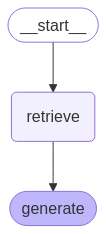

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Ejecuta el flujo del gráfico con la pregunta "What is Task Decomposition?", obtiene el contexto relevante y genera una respuesta, luego imprime ambos.

In [ ]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Ejecuta el flujo del gráfico en modo de transmisión, mostrando actualizaciones paso a paso de la ejecución del proceso.

In [ ]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

Transmite los mensajes generados por el gráfico en tiempo real, imprimiendo el contenido de cada mensaje seguido de |.

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

# Personalizar el mensaje

In [17]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

# Análisis de consultas

Emplea modelos para transformar o construir consultas de búsqueda optimizadas a partir de la información sin procesar del usuario. 

In [18]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

Actualizar los documentos en nuestro almacén de vectores. 

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Define un diccionario tipado para representar una consulta de búsqueda con una pregunta y una sección específica.

In [6]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Generar una consulta a partir de la entrada sin procesar del usuario:

In [ ]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

Probar nuestra implementación solicitando específicamente el contexto al final de la publicación.

In [ ]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

# Herramientas utilizadas en este proyecto

1. LangChain - Framework para construir aplicaciones con modelos de lenguaje.

2. LangChain Hub - Repositorio de prompts predefinidos.

3. LangChain Community - Módulos adicionales como WebBaseLoader para cargar documentos web.

4. LangChain Core - Componentes esenciales como Document y StateGraph.

5. Pinecone - Base de datos vectorial para almacenar y recuperar documentos.

6. OpenAI - Proveedor de embeddings y modelos de lenguaje.

7. BeautifulSoup (bs4) - Para extraer contenido específico de páginas web.

8. IPython.display - Para visualizar gráficos generados con graph.draw_mermaid_png().

9. Typing Extensions - Para definiciones avanzadas de tipos como TypedDict y Annotated.

# Desarrollado por : Laura Valentina Rodríguez Ortegón